##### Dmytro Romaniv 151958 and Patryk Maciejewski 151960

### Our game of choice - Chess

Chess is a two-player strategy board game played on a checkered board with 64 squares arranged in an 8×8 grid. The game is played by millions of people worldwide. Chess is believed to be derived from the Indian game chaturanga some time before the 7th century. Chaturanga is also the likely ancestor of the Eastern strategy games xiangqi (Chinese chess), janggi (Korean chess), and shogi (Japanese chess). Chess reached Europe by the 9th century, due to the Umayyad conquest of Hispania. The pieces assumed their current powers in Spain in the late 15th century; the modern rules were standardized in the 19th century.

List of in-game items e.g. counters, dices, cards and what are their types or number, boards, figures:

- 1 board (8x8 checkered squares)
- 2 sets of 16 pieces (1 king, 1 queen, 2 rooks, 2 bishops, 2 knights, and 8 pawns) of opposing colors (white and black)
- 1 chess clock (optional)

Description of at least 5 events occurring in the game:

- Checkmate - the game ends immediately
- Draw - the game ends immediately
- En passant - a special pawn capture
- Castling - a special king move
- Promotion - a pawn reaching the opponent's side of the board is promoted to another piece

In [71]:
import cv2
import numpy as np
from PIL import Image

In [72]:
def imshow(a):
    """
    Display an image using matplotlib.

    Parameters:
    a (numpy.ndarray): The input image array.

    Returns:
    None
    """
    a = a.clip(0, 255).astype("uint8")
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(a))

In [73]:
def load_video(path):
    """
    Loads a video from the specified path and returns the video capture object, height, width, and frames per second (fps).

    Parameters:
    path (str): The path to the video file.

    Returns:
    cap (cv2.VideoCapture): The video capture object.
    h (int): The height of the video frames.
    w (int): The width of the video frames.
    fps (float): The frames per second of the video.
    """
    cap = cv2.VideoCapture(path)
    if cap.isOpened():
        print(f"Opened the file `{path}` successfully.")
    
    # Height and width and fps of the video
    h = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    w = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    fps = cap.get(cv2.CAP_PROP_FPS)

    return cap, int(h), int(w), fps

### Description of the dataset

The dataset contains of 9 one-minute clips, 3 for each difficulty (easy, medium, hard).
Each clip is from the same continuous game played by two people.

The videos were recorded using a handheld iPhone 13 and compressed using the H.264 codec for optimization purposes.
Each video has a resolution of (848, 768) and a framerate of 30 fps.

- Easy clips have a good, top-down view of the board and great lighting.
- Medium clips have the same view as the easy clips, but the lighting is worse.
- Hard clips have an agled view of the board and the same lighting as the medium clips.

Opened the file `input/easy2.mp4` successfully.
Opened the file `input/medium2.mp4` successfully.
Opened the file `input/hard2.mp4` successfully.


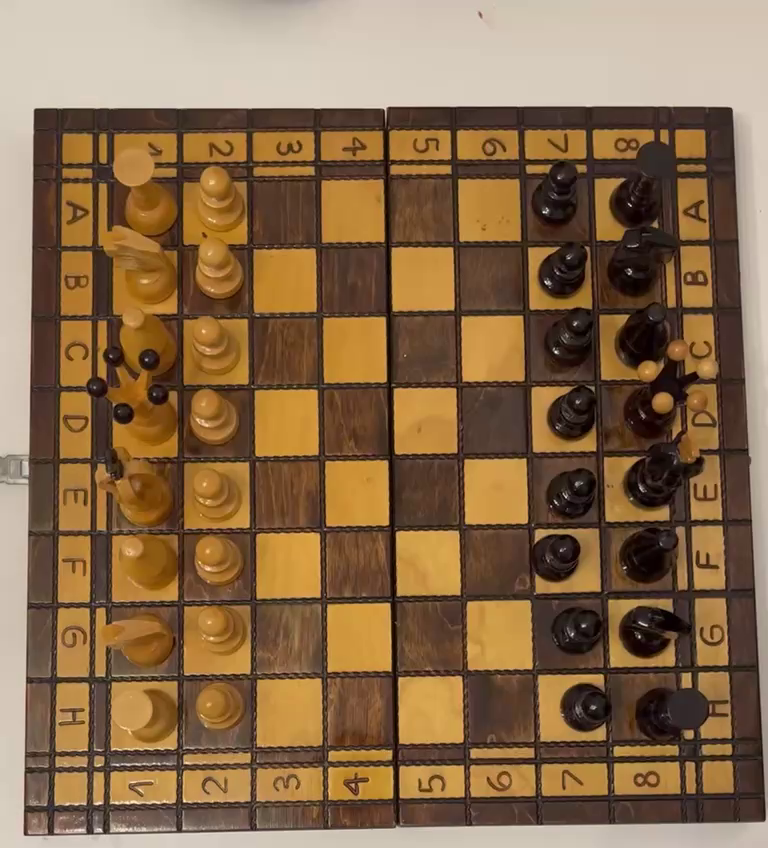

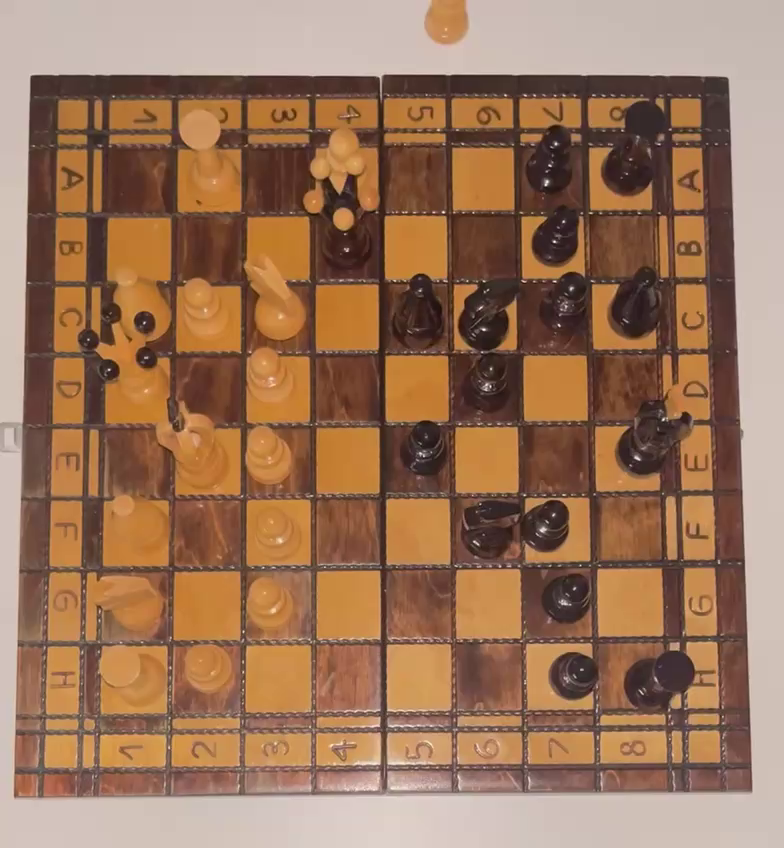

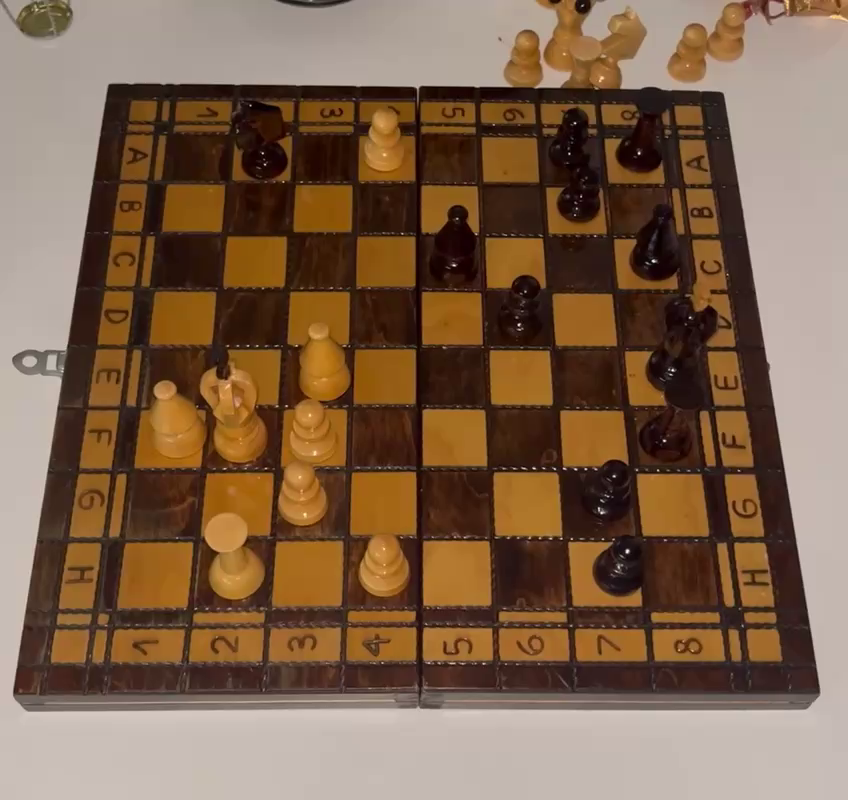

In [74]:
easy_cap, easy_h, easy_w, easy_fps = load_video("input/easy2.mp4")
medium_cap, medium_h, medium_w, medium_fps = load_video("input/medium2.mp4")
hard_cap, hard_h, hard_w, hard_fps = load_video("input/hard2.mp4")

_, easy_frame = easy_cap.read()
_, medium_frame = medium_cap.read()
_, hard_frame = hard_cap.read()

imshow(easy_frame)
imshow(medium_frame)
imshow(hard_frame)

Below are some function definitions that will be used later on, go furhter down to see step-by-step analysis.

In [75]:
def estimate_color(img, circle):
    """
    Estimates the color of a chess piece based on its average brightness.

    Parameters:
    img (numpy.ndarray): The original image.
    circle (tuple): The coordinates and radius of the circle enclosing the chess piece.

    Returns:
    str: The estimated color of the chess piece ("white" or "black").
    """
    # Crop the piece image from the original image
    x, y, r = circle
    piece_img = img[y - r : y + r, x - r : x + r]

    # Calculate the average brightness of the piece
    avg_brightness = np.mean(piece_img)

    # If the average brightness is greater than 150, the piece is white
    if avg_brightness > 64:
        return "white"
    else:
        return "black"

In [76]:
def estimate_piece_template(img, circle):
    """
    Estimates the type of chess piece based on a given frame and circle using template matching.

    Args:
        img (numpy.ndarray): The original image containing the chessboard.
        circle (tuple): The coordinates (x, y, r) of the circle representing the chess piece.

    Returns:
        str: The estimated type of chess piece ('king', 'queen', 'rook', 'bishop', 'knight', 'pawn').
    """
    # Crop the piece image from the original image
    x, y, r = circle
    piece_img = img[
        int(y - r * 1.5) : int(y + r * 1.5), int(x - r * 1.5) : int(x + r * 1.5)
    ]

    # Convert the image to grayscale
    piece_gray = cv2.cvtColor(piece_img, cv2.COLOR_BGR2GRAY)

    # Match the piece image with the template images
    match_results = []
    pieces = ["king", "queen", "rook", "bishop", "knight", "pawn"]
    for piece in pieces:
        template = cv2.imread(f"templates/{piece}.png", cv2.IMREAD_GRAYSCALE)
        resized_piece = cv2.resize(piece_gray, (template.shape[1], template.shape[0]))
        res = cv2.matchTemplate(resized_piece, template, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        match_results.append((max_val, piece))

    # Find the piece with the highest matching score
    _, best_match = max(match_results, key=lambda x: x[0])

    return best_match

In [77]:
def estimate_piece_keypoint(img, circle):
    """
    Estimates the type of chess piece based on the given image and circle using the SIFT algorithm.

    Args:
        img (numpy.ndarray): The original image.
        circle (tuple): The circle coordinates (x, y, r) representing the piece.

    Returns:
        str: The estimated type of chess piece ('king', 'queen', 'rook', 'bishop', 'knight', 'pawn').
    """
    # Crop the piece image from the original image
    x, y, r = circle
    piece_img = img[
        int(y - r * 1.5) : int(y + r * 1.5), int(x - r * 1.5) : int(x + r * 1.5)
    ]

    # Convert the image to grayscale
    piece_gray = cv2.cvtColor(piece_img, cv2.COLOR_BGR2GRAY)

    # Adjust SIFT parameters if needed
    sift = cv2.SIFT_create()

    # Detect and compute keypoints and descriptors
    kp_piece, des_piece = sift.detectAndCompute(piece_gray, None)

    pieces = ["king", "queen", "rook", "bishop", "knight", "pawn"]
    best_match = None
    min_avg_distance = float("inf")

    for piece in pieces:
        template = cv2.imread(f"templates/{piece}.png", cv2.IMREAD_GRAYSCALE)
        kp_template, des_template = sift.detectAndCompute(template, None)

        # FLANN parameters
        index_params = dict(algorithm=1, trees=5)
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)

        matches = flann.knnMatch(des_piece, des_template, k=2)

        # Apply ratio test
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)

        # Calculate the average distance of good matches
        if good_matches:
            avg_distance = np.mean([m.distance for m in good_matches])
            if avg_distance < min_avg_distance:
                min_avg_distance = avg_distance
                best_match = piece

    return best_match

In [78]:
def get_chess_coord(idx):
    """
    Converts a linear index to chessboard coordinates.

    Parameters:
    idx (int): The linear index of the chessboard position.

    Returns:
    str: The chessboard coordinates corresponding to the given index.
    """

    # Get the chessboard coordinates
    x = idx % 8
    y = idx // 8

    # Convert the coordinates to chessboard coordinates
    x = chr(ord("a") + x)
    y = 1 + y

    return f"{x}{y}"

Let's walk through the analysis of the first frame of the first clip.

First the image is preprocessesed. 
Then we find the board using a mix of hough lines and contours and square calculations.
We find the pieces using hough circles, their color using the average color of the piece, and their type using template matching (results are not great).
Before drawing we make sure that all the data is correct and consistent across the last few frames.
Finally we check the variables and add text for the events and counters.

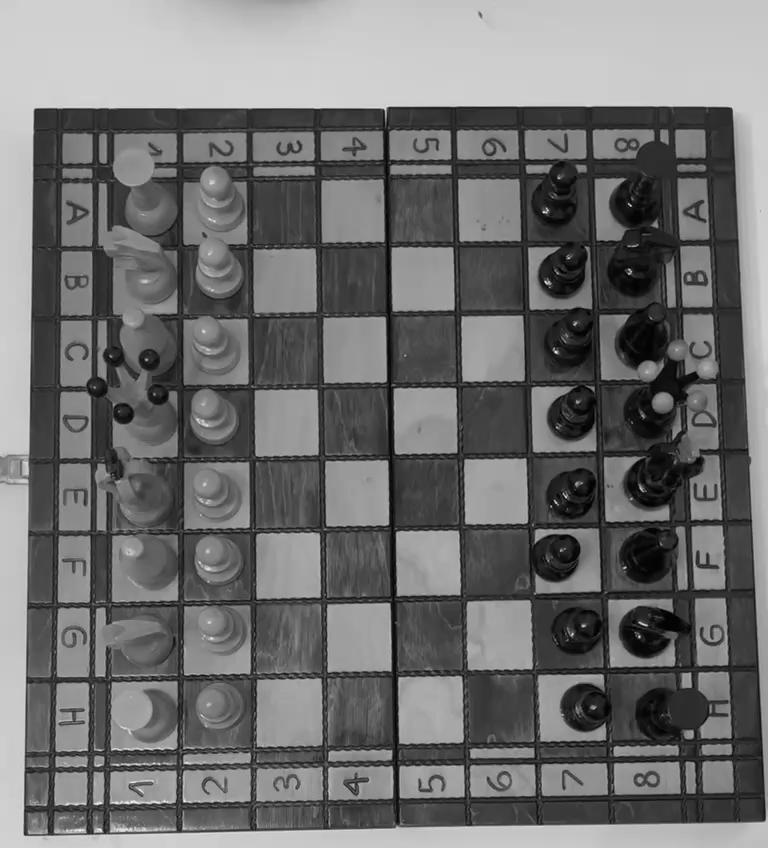

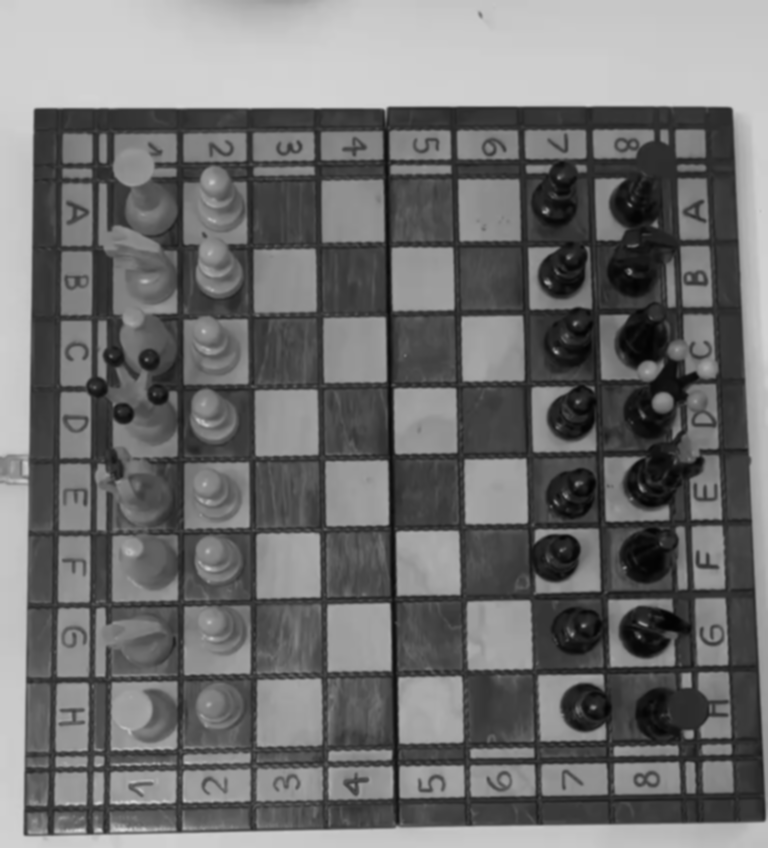

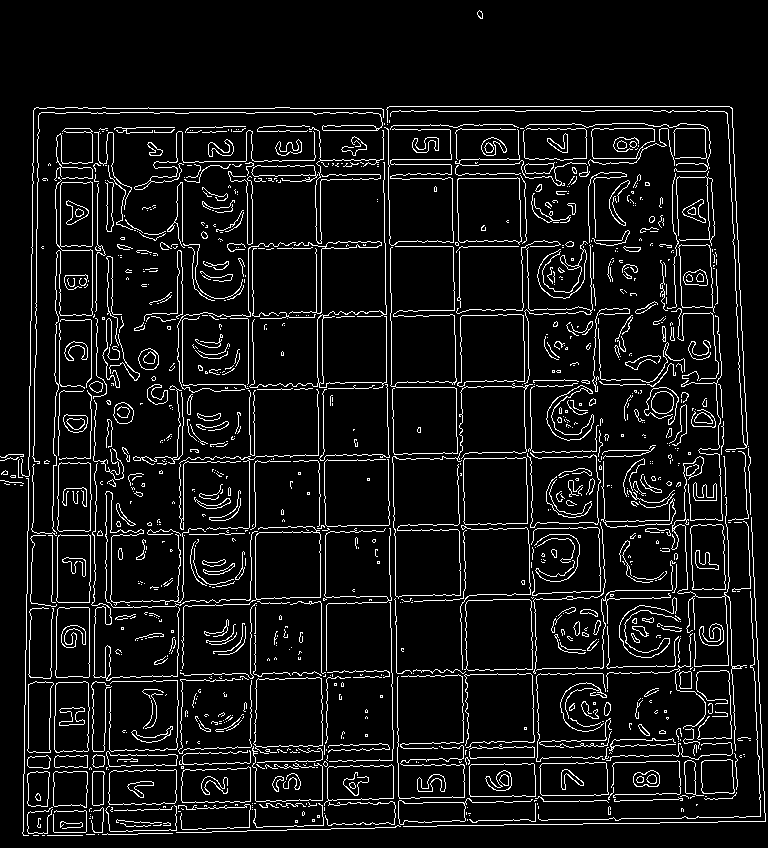

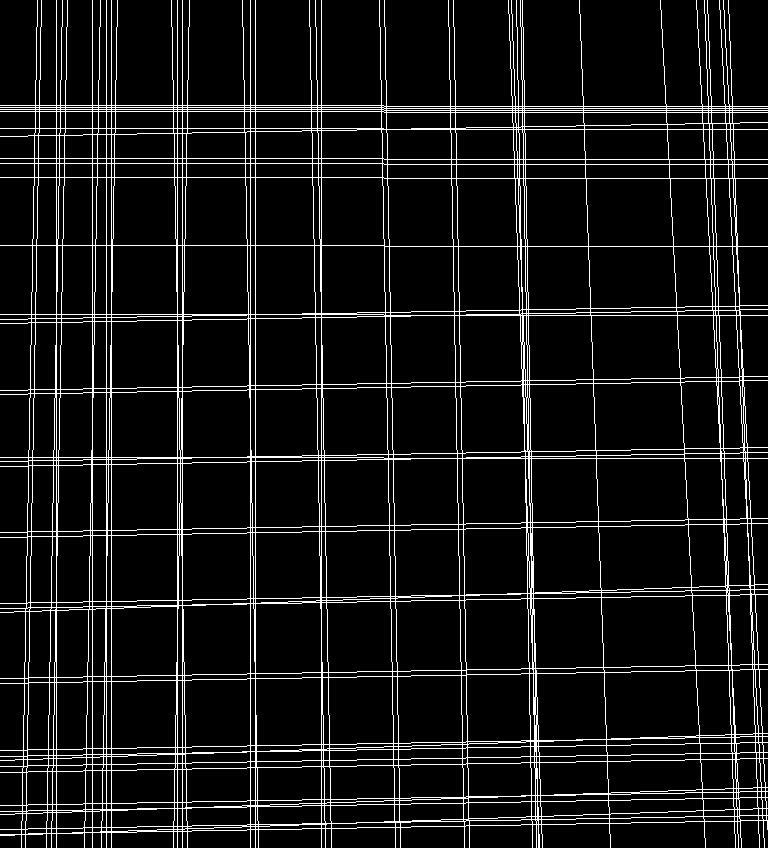

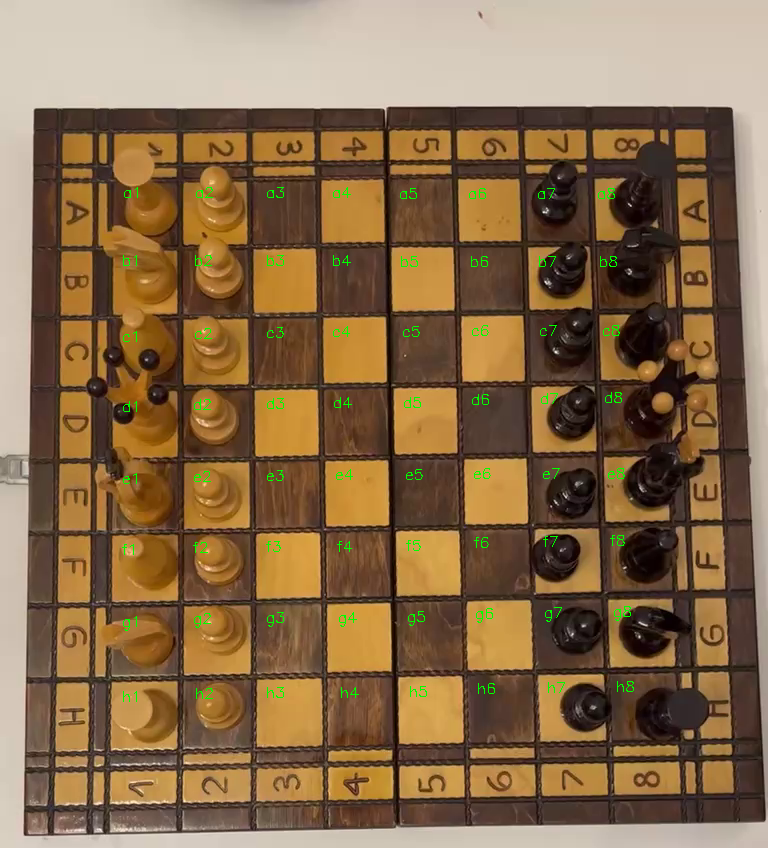

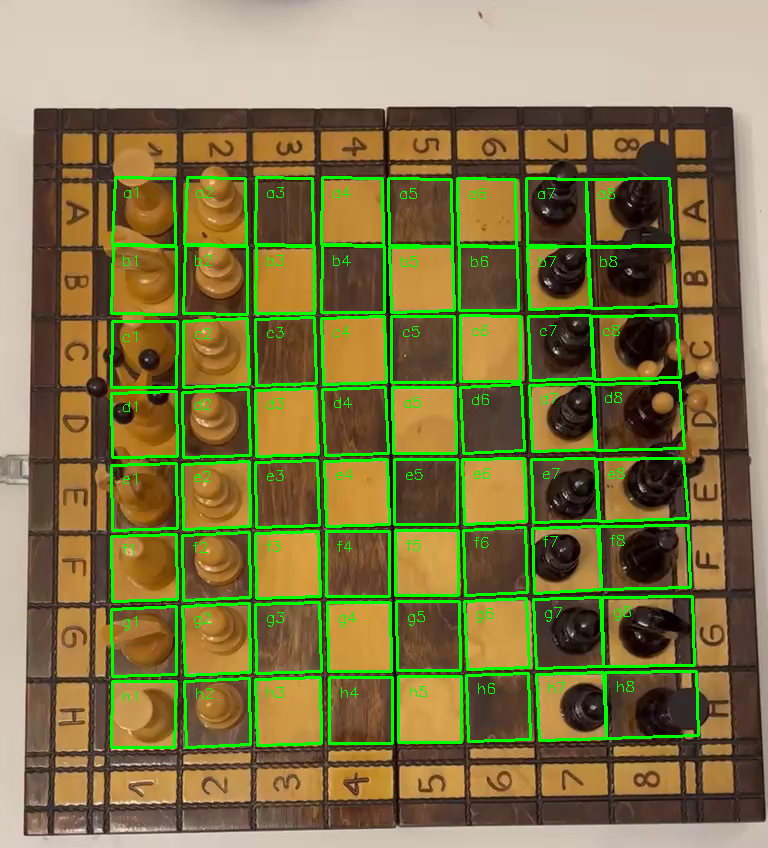

{'a1': 'white', 'b1': 'white', 'c1': 'white', 'd1': None, 'e1': 'white', 'f1': 'white', 'g1': 'white', 'h1': 'white', 'a2': 'white', 'b2': 'white', 'c2': 'white', 'd2': 'white', 'e2': 'white', 'f2': 'white', 'g2': 'white', 'h2': 'white', 'a3': None, 'b3': None, 'c3': None, 'd3': None, 'e3': None, 'f3': None, 'g3': None, 'h3': None, 'a4': None, 'b4': None, 'c4': None, 'd4': None, 'e4': None, 'f4': None, 'g4': None, 'h4': None, 'a5': None, 'b5': None, 'c5': None, 'd5': None, 'e5': None, 'f5': None, 'g5': None, 'h5': None, 'a6': None, 'b6': None, 'c6': None, 'd6': None, 'e6': None, 'f6': None, 'g6': None, 'h6': None, 'a7': 'black', 'b7': 'black', 'c7': 'black', 'd7': 'black', 'e7': 'black', 'f7': 'black', 'g7': 'black', 'h7': 'black', 'a8': 'black', 'b8': 'black', 'c8': 'black', 'd8': 'black', 'e8': 'black', 'f8': 'black', 'g8': 'black', 'h8': 'black'}


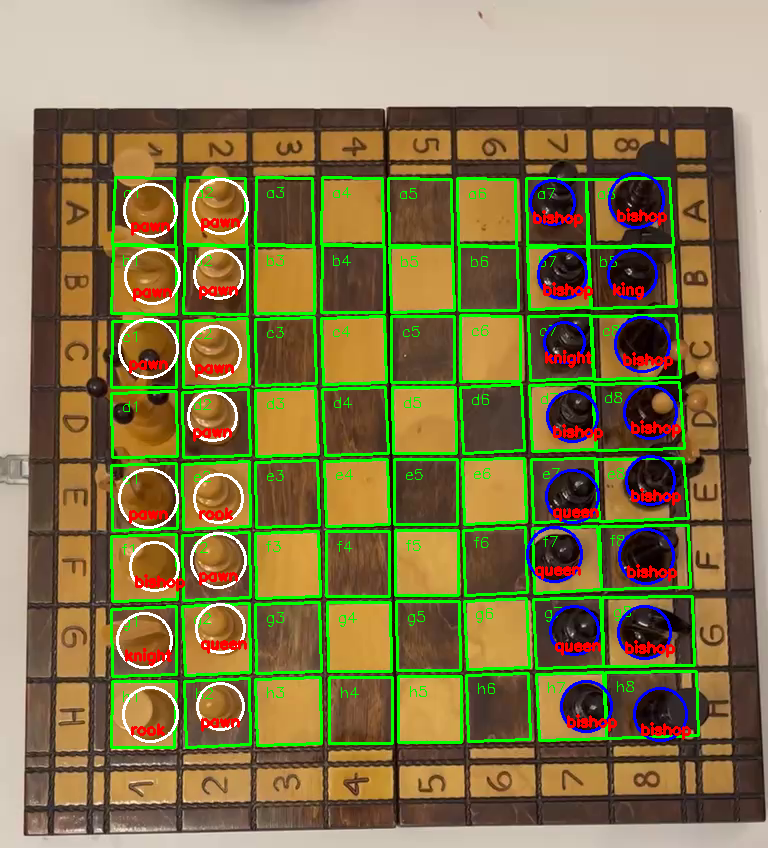

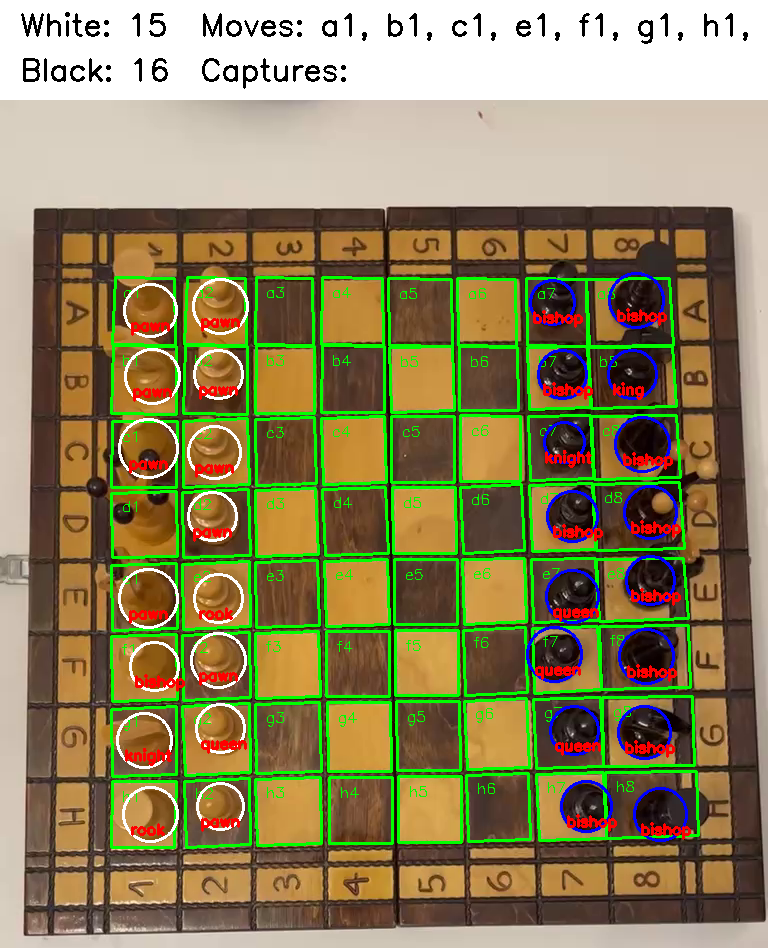

In [79]:
frame = easy_frame.copy()

# Initialize counter variables
squares_with_circles = [[] for _ in range(64)]
old_circles = []
old_squares = []

# Initialize empty chessboard matrix
chessboard = { get_chess_coord(idx): None for idx in range(64) }
old_chessboard = chessboard.copy()
changed_positions = {"moves": [], "captures": []}
old_changed_positions = changed_positions.copy()

# Convert the frame to grayscale
frame_gray = cv2.cvtColor(easy_frame, cv2.COLOR_BGR2GRAY)
imshow(frame_gray)

# Apply GaussianBlur to reduce noise and improve circle detection
frame_blur = cv2.GaussianBlur(frame_gray, (5, 5), 0)
imshow(frame_blur)

# Threshold the image and get the edges to isolate the board
frame_th = cv2.adaptiveThreshold(
    frame_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 10
)
frame_edges = cv2.Canny(frame_th, 50, 150)
imshow(frame_edges)

# Find HoughLines on the board
lines = cv2.HoughLines(frame_edges, 1, np.pi / 180, 180)

# Negative mask of the lines
mask = np.zeros(frame_edges.shape[:2], dtype=np.uint8)

# Draw the lines on the mask
for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)

    x0 = a * rho
    y0 = b * rho

    x1 = int(x0 + 1000 * -b)
    y1 = int(y0 + 1000 * a)

    x2 = int(x0 - 1000 * -b)
    y2 = int(y0 - 1000 * a)

    cv2.line(mask, (x1, y1), (x2, y2), (255, 255, 255), 1)
imshow(mask)

# Find the contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# In the meantime, we will look for the chessboard pieces as circles.

# Use HoughCircles to detect circles
detected_circles = cv2.HoughCircles(
    frame_blur,
    cv2.HOUGH_GRADIENT,
    dp=1,
    minDist=60,
    param1=50,
    param2=20,
    minRadius=20,
    maxRadius=30,  # changet to 35 for more false positives (30 for less)
)

detected_circles = np.uint16(np.around(detected_circles))[0]

# Get actual chessboard squares from the contours
squares = []
for cnt in contours[1:]:
    # Approximate the contour to a polygon
    epsilon = 0.1 * cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)

    # Check if the polygon has 4 sides
    if len(approx) == 4:
        # Use minimum area rectangle to consider rotation
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)

        # Calculate width and height of the rectangle
        width = np.linalg.norm(box[0] - box[1])
        height = np.linalg.norm(box[1] - box[2])
        area = width * height

        aspectRatio = max(width, height) / min(width, height)
        if 1 <= aspectRatio <= 1.5 and 3000 < area < 7000:
            squares.append(approx)

# Sort the squares from left to right
sorted_squares = sorted(squares, key=lambda x: np.mean(x[:, 0, 0]))

# In each column, sort the squares from top to bottom
for i in range(8):
    sorted_squares[i * 8 : (i + 1) * 8] = sorted(
        sorted_squares[i * 8 : (i + 1) * 8], key=lambda x: np.mean(x[:, 0, 1])
    )

# Find the square coordinates and assign the circles to the squares
for idx, square in enumerate(sorted_squares):
    x, y, w, h = cv2.boundingRect(square)

    # Get the chessboard coordinates of the square
    coord = get_chess_coord(idx)

    # Assign circle to the square
    for circle in detected_circles:
        a, b, r = circle

        # Check if the circle center is inside the square
        if cv2.pointPolygonTest(square, (a, b), False) == 1:
            # Estimate the color of the piece
            color = estimate_color(frame, circle)

            # Estimate the type of the piece
            piece = estimate_piece_template(frame, circle)

            # Add the circle to the list of circles in the square
            squares_with_circles[idx].append((circle, color, piece))

    # Draw the coordinates
    cv2.putText(
        frame,
        coord,
        (x + 10, y + 20),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 255, 0),
        1,
    )
imshow(frame)

# If all squares are found, draw them, otherwise draw the last known squares
if len(squares) == 64:
    cv2.drawContours(frame, squares, -1, (0, 255, 0), 2)
    old_squares = squares.copy()
else:
    cv2.drawContours(frame, old_squares, -1, (0, 255, 0), 2)
imshow(frame)

# This part is needed for the video and doesn't make sense for a single image. (it's slighly modified here)
# In a video, it looks for circles that appeared at least 3 times in the last 30 frames.
# If a circle is found, it is added to the list of circles to draw and the chessboard matrix is updated with the according color.
circles_to_draw = []
for idx, circle in enumerate(squares_with_circles):
    if len(circle) > 0:
        selected = max(circle, key=lambda x: x[1])
        circles_to_draw.append(selected)
        chessboard[get_chess_coord(idx)] = selected[1]
    else:
        chessboard[get_chess_coord(idx)] = None
old_circles = circles_to_draw.copy()
squares_with_circles = [[] for _ in range(64)]

# Notice if the chessboard has changed and note the according play
changed_positions = {"moves": [], "captures": []}
for key, value in chessboard.items():
    if value != old_chessboard[key]:
        if old_chessboard[key] is None:
            changed_positions['moves'].append(key)
        elif chessboard[key] is None:
            pass
        else:
            changed_positions['captures'].append(key)
print(chessboard)
old_chessboard = chessboard.copy()


# Draw the circles on the original image
for circle, color, piece in old_circles:
    a, b, r = circle

    # Draw the circle
    if color == "black":
        cv2.circle(frame, (a, b), r, (255, 0, 0), 2)
    else:
        cv2.circle(frame, (a, b), r, (255, 255, 255), 2)

    # Annotate the piece
    cv2.putText(
        frame,
        piece,
        (a - 20, b + 20),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 0, 255),
        2,
    )
imshow(frame)

# Count the number of white and black pieces
white_count = len([x for x in old_circles if x[1] == "white"])
black_count = len([x for x in old_circles if x[1] == "black"])

# Add a white space to the top of the image
frame = cv2.copyMakeBorder(
    frame, 100, 0, 0, 0, cv2.BORDER_CONSTANT, value=(255, 255, 255)
)

# Draw the white and black counts
cv2.putText(
    frame,
    f"White: {white_count}",
    (20, 35),
    cv2.FONT_HERSHEY_SIMPLEX,
    1,
    (0, 0, 0),
    2,
)
cv2.putText(
    frame,
    f"Black: {black_count}",
    (20, 80),
    cv2.FONT_HERSHEY_SIMPLEX,
    1,
    (0, 0, 0),
    2,
)

# Display the moves and captures found 
if changed_positions != old_changed_positions:
    cv2.putText(
        frame,
        "Moves: " + ", ".join(changed_positions['moves']),
        (200, 35),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 0, 0),
        2,
    )
    cv2.putText(
        frame,
        "Captures: " + ", ".join(changed_positions['captures']),
        (200, 80),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 0, 0),
        2,
    )

imshow(frame)

In [80]:
def process_video(input_file_path: str, output_file_path: str) -> None:
    """
    Process a video file for chess detection.

    Args:
        input_file_path (str): The path to the input video file.
        output_file_path (str): The path to save the output video file.

    Returns:
        None
    """
    test_video, test_height, test_width, test_FPS = load_video(input_file_path)

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*"DIVX")
    test_red_clip = cv2.VideoWriter(
        output_file_path, fourcc, test_FPS, (test_width, test_height + 100)
    )

    frame_number = 0

    squares_with_circles = [[] for _ in range(64)]
    old_circles = []
    old_squares = []

    # Initialize empty chessboard
    chessboard = { get_chess_coord(idx): None for idx in range(64) }
    old_chessboard = chessboard.copy()
    changed_positions = {"moves": [], "captures": []}
    old_changed_positions = changed_positions.copy()

    while test_video.isOpened():
        ret, frame = test_video.read()
        frame_number += 1
        if not ret:
            break  # Exit the loop when no frames are retrieved

        # Convert the frame to grayscale
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Apply GaussianBlur to reduce noise and improve circle detection
        frame_blur = cv2.GaussianBlur(frame_gray, (5, 5), 0)

        # Board detection
        frame_th = cv2.adaptiveThreshold(
            frame_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 10
        )
        frame_edges = cv2.Canny(frame_th, 50, 150)

        # Find HoughLines
        lines = cv2.HoughLines(frame_edges, 1, np.pi / 180, 180)

        # Negative mask of the lines
        mask = np.zeros(frame_edges.shape[:2], dtype=np.uint8)

        # Draw the lines on the mask
        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)

            x0 = a * rho
            y0 = b * rho

            x1 = int(x0 + 1000 * -b)
            y1 = int(y0 + 1000 * a)

            x2 = int(x0 - 1000 * -b)
            y2 = int(y0 - 1000 * a)

            cv2.line(mask, (x1, y1), (x2, y2), (255, 255, 255), 1)

        # Find the contours in the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Use HoughCircles to detect circles
        detected_circles = cv2.HoughCircles(
            frame_blur,
            cv2.HOUGH_GRADIENT,
            dp=1,
            minDist=60,
            param1=50,
            param2=20,
            minRadius=20,
            maxRadius=30,  # changet to 35 for more false positives (30 for less)
        )

        detected_circles = np.uint16(np.around(detected_circles))[0]

        # Return squares and circles
        squares = []
        for cnt in contours[1:]:
            # Approximate the contour to a polygon
            epsilon = 0.1 * cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, epsilon, True)

            # Check if the polygon has 4 sides
            if len(approx) == 4:
                # Use minimum area rectangle to consider rotation
                rect = cv2.minAreaRect(cnt)
                box = cv2.boxPoints(rect)
                box = np.int0(box)

                # Calculate width and height of the rectangle
                width = np.linalg.norm(box[0] - box[1])
                height = np.linalg.norm(box[1] - box[2])
                area = width * height

                aspectRatio = max(width, height) / min(width, height)
                if 1 <= aspectRatio <= 1.5 and 3000 < area < 7000:
                    squares.append(approx)

        # Sort the squares from left to right
        sorted_squares = sorted(old_squares, key=lambda x: np.mean(x[:, 0, 0]))

        # In each column, sort the squares from top to bottom
        for i in range(8):
            sorted_squares[i * 8 : (i + 1) * 8] = sorted(
                sorted_squares[i * 8 : (i + 1) * 8], key=lambda x: np.mean(x[:, 0, 1])
            )

        # Draw each square and annotate it
        for idx, square in enumerate(sorted_squares):
            # Draw the square (example: using bounding box)
            x, y, w, h = cv2.boundingRect(square)

            # Annotate with chessboard coordinates
            coord = get_chess_coord(idx)

            # Assign circle to the square
            for circle in detected_circles:
                a, b, r = circle

                # Check if the circle center is inside the square
                if cv2.pointPolygonTest(square, (a, b), False) == 1:
                    # Estimate the color of the piece
                    color = estimate_color(frame, circle)

                    # Estimate the piece
                    piece = estimate_piece_template(frame, circle)

                    squares_with_circles[idx].append((circle, color, piece))

            cv2.putText(
                frame,
                coord,
                (x + 10, y + 20),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0, 255, 0),
                1,
            )

        # Draw the squares on the original image
        if len(squares) == 64:
            cv2.drawContours(frame, squares, -1, (0, 255, 0), 2)
            old_squares = squares.copy()
        else:
            cv2.drawContours(frame, old_squares, -1, (0, 255, 0), 2)

        # Every second find the circles to draw
        if frame_number % 30 == 0:
            circles_to_draw = []
            for idx, circle in enumerate(squares_with_circles):
                if len(circle) > 3:
                    selected = max(circle, key=lambda x: x[1])
                    circles_to_draw.append(selected)
                    chessboard[get_chess_coord(idx)] = selected[1]
                else:
                    chessboard[get_chess_coord(idx)] = None
            old_circles = circles_to_draw.copy()
            squares_with_circles = [[] for _ in range(64)]

            # Notice if the chessboard has changed
            changed_positions = {"moves": [], "captures": []}
            for key, value in chessboard.items():
                if value != old_chessboard[key]:
                    if old_chessboard[key] is None:
                        changed_positions['moves'].append(key)
                    elif chessboard[key] is None:
                        pass
                    else:
                        changed_positions['captures'].append(key)
            old_chessboard = chessboard.copy()


        # Draw the circles on the original image
        for circle, color, piece in old_circles:
            a, b, r = circle

            # Draw the circle
            if color == "black":
                cv2.circle(frame, (a, b), r, (255, 0, 0), 2)
            else:
                cv2.circle(frame, (a, b), r, (255, 255, 255), 2)

            # Annotate the piece
            cv2.putText(
                frame,
                piece,
                (a - 20, b + 20),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0, 0, 255),
                2,
            )

        white_count = len([x for x in old_circles if x[1] == "white"])
        black_count = len([x for x in old_circles if x[1] == "black"])

        # Add a white space to the top of the image
        frame = cv2.copyMakeBorder(
            frame, 100, 0, 0, 0, cv2.BORDER_CONSTANT, value=(255, 255, 255)
        )

        # Draw the white and black counts
        cv2.putText(
            frame,
            f"White: {white_count}",
            (20, 35),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 0, 0),
            2,
        )
        cv2.putText(
            frame,
            f"Black: {black_count}",
            (20, 80),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 0, 0),
            2,
        )

        # Display the moves and captures found 
        if changed_positions != old_changed_positions and frame_number >= 60:
            cv2.putText(
                frame,
                "Moves: " + ", ".join(changed_positions['moves']),
                (200, 35),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (0, 0, 0),
                2,
            )
            cv2.putText(
                frame,
                "Captures: " + ", ".join(changed_positions['captures']),
                (200, 80),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (0, 0, 0),
                2,
            )

        test_red_clip.write(frame)


    test_video.release()  # Release the video capture
    test_red_clip.release() # Release the video writer
    print(f"Saved the file `{output_file_path}` successfully.")

In [81]:
categories = ["easy", "medium", "hard"]
clips = 3
for category in categories:
    for clip in range(1, clips + 1):
        process_video(f"input/{category}{clip}.mp4", f"output/{category}{clip}_output.mp4")

Opened the file `input/easy1.mp4` successfully.
Saved the file `output/easy1_output.mp4` successfully.
Opened the file `input/easy2.mp4` successfully.
Saved the file `output/easy2_output.mp4` successfully.
Opened the file `input/easy3.mp4` successfully.
Saved the file `output/easy3_output.mp4` successfully.
Opened the file `input/medium1.mp4` successfully.
Saved the file `output/medium1_output.mp4` successfully.
Opened the file `input/medium2.mp4` successfully.
Saved the file `output/medium2_output.mp4` successfully.
Opened the file `input/medium3.mp4` successfully.
Saved the file `output/medium3_output.mp4` successfully.
Opened the file `input/hard1.mp4` successfully.
Saved the file `output/hard1_output.mp4` successfully.
Opened the file `input/hard2.mp4` successfully.
Saved the file `output/hard2_output.mp4` successfully.
Opened the file `input/hard3.mp4` successfully.
Saved the file `output/hard3_output.mp4` successfully.


From these clips we can indentify the effectiveness for each dataset:

- The easy dataset obviously has the best results. It's very consistent in finding the board and the pieces, just sometimes it has trouble with the color.
- The medium dataset is also pretty good, it has no trouble with the board, but sometimes it struggles in finding badly lit pieces.
- The hard dataset is the worst, the board is still fairly easy to find, but the pieces are a lot harder to find, especially the black ones.

Based on these results, we can conclude that:

- The piece classification is the hardest part of the project and unfortunately we didn't manage to get it to work very well.
- The board identification is a technologically impressive feat and it's accuracy is very good and and it's speed is not bad either.
- The piece identification is a lot harder than the board identification, but it's still possible to get good results.

Overall, we are very happy with the results, we managed to get a working chessboard and piece detection system, which is what we set out to do in the first plaec. We wish we had more time to work on the piece classification, but we are still happy with the results we got.